In [1]:
from collections import defaultdict
import math
from pathlib import Path
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.io.wavfile import read as wavread
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn.svm import SVC
from textgrids import TextGrid

import IPython.display as ipd

In [2]:
def fix_length(array, desired_length: int):
    """ Helper function to make all arrays the same length in third dimension """
    if array.shape[2] > desired_length:
        return array[:, :, :desired_length]
    elif array.shape[2] < desired_length:
        return np.concatenate([
            array, 
            np.zeros((array.shape[0], array.shape[1], desired_length - array.shape[2]))
        ], axis=2)
    else:
        return array

def fix_length_2d_dim1(array, desired_length: int):
    """ Helper function to make all arrays the same length in third dimension """
    if array.shape[1] > desired_length:
        return array[:, :desired_length]
    elif array.shape[1] < desired_length:
        return np.concatenate([
            array, 
            np.zeros((array.shape[0], desired_length - array.shape[1]))
        ], axis=1)
    else:
        return array

def normalize(array, minval: float, maxval: float):
    """ Helper function to normalize array from range `[minval,maxval]` to `[0,1]`. """
    return (array - minval) / (maxval - minval)

The following cell contains the intersection of words between the HP chapter 1 and the VariaNTS corpus. 

If we want to select only certain classes to make training easier, we can do that here by commenting out line 7. Note that *dag* and *wel* are the most frequent words in the HP chapter.

In [415]:
# The words that overlap between HP chapter 1 and the VariaNTS corpus are hardcoded here for brevity
variaNTS_intersection = 'bed,boel,brief,bril,dag,dier,doel,dood,feest,goed,greep,half,hand,heel,heer,hoofd,hoop,kalm,kan,kant,keel,keer,kind,klein,kneep,kwaad,laat,land,lang,licht,los,man,meer,mond,mot,neus,paar,raam,rest,snel,stad,steen,stijf,stuur,tijd,vol,vorm,vroeg,weg,wel,werk,wind,zet,zin,zoon'

variaNTS_intersection = variaNTS_intersection.split(',')

# If we want to select only certain classes, we can do that here:
# variaNTS_intersection = ['dag', 'wel']
# variaNTS_intersection = ['perkamentus', 'anderling']
# variaNTS_intersection = ['perkamentus', 'anderling','maar', 'niet', 'zijn']
# variaNTS_intersection = ['wel', 'dag', 'goed', 'paar', 'lang', 'hoofd']
# variaNTS_intersection = ['lang', 'paar']

print(variaNTS_intersection)

['bed', 'boel', 'brief', 'bril', 'dag', 'dier', 'doel', 'dood', 'feest', 'goed', 'greep', 'half', 'hand', 'heel', 'heer', 'hoofd', 'hoop', 'kalm', 'kan', 'kant', 'keel', 'keer', 'kind', 'klein', 'kneep', 'kwaad', 'laat', 'land', 'lang', 'licht', 'los', 'man', 'meer', 'mond', 'mot', 'neus', 'paar', 'raam', 'rest', 'snel', 'stad', 'steen', 'stijf', 'stuur', 'tijd', 'vol', 'vorm', 'vroeg', 'weg', 'wel', 'werk', 'wind', 'zet', 'zin', 'zoon']


In [416]:
THRESHOLD = 13

variaNTS_intervals = []
for RUN in [1,2]:
    textgrid = TextGrid(subj_dir / f'sub-00{SUB}_ses-iemu_acq-ECOG_run-0{RUN}_audio.TextGrid')

    variaNTS_intervals.extend([
        interval for interval in textgrid['words']
        if interval.text in variaNTS_intersection
    ])

word_counts = dict(zip(*np.unique([intrvl.text for intrvl in variaNTS_intervals], return_counts=True)))
word_counts = dict(reversed(sorted(word_counts.items(), key=lambda item: item[1])))
print(word_counts)

selected_words = dict([item for item in word_counts.items() if item[1] >= THRESHOLD])
variaNTS_intersection = list(selected_words.keys())

print(variaNTS_intersection)
len(variaNTS_intersection)

{'wel': 18, 'dag': 13, 'goed': 9, 'paar': 8, 'lang': 8, 'hoofd': 8, 'meer': 7, 'keer': 7, 'kan': 7, 'heel': 7, 'vroeg': 6, 'los': 6, 'land': 5, 'half': 5, 'brief': 5, 'weg': 4, 'tijd': 4, 'man': 4, 'hoop': 4, 'raam': 3, 'klein': 3, 'hand': 3, 'dood': 3, 'werk': 2, 'vorm': 2, 'stad': 2, 'neus': 2, 'mond': 2, 'laat': 2, 'kind': 2, 'kant': 2, 'greep': 2, 'bril': 2, 'bed': 2, 'zoon': 1, 'zin': 1, 'zet': 1, 'wind': 1, 'vol': 1, 'stuur': 1, 'stijf': 1, 'snel': 1, 'rest': 1, 'licht': 1, 'kwaad': 1, 'kneep': 1, 'keel': 1, 'kalm': 1, 'heer': 1, 'feest': 1, 'doel': 1, 'dier': 1, 'boel': 1}
['wel', 'dag']


2

The following cell creates trainable data (ECoG segments matched with labels) from the original dataframes. 

For each subject, there are two recording runs, and per run, there are two frequency bands (high and low). For the words that we are interested in, we get the appropriate timestamps from a `TextGrid` file, that we use to cut out segments from the dataframes containing the ECoG recordings in the two frequency bands. 

For each cut-out segment, we therefore have two dataframe sections, that we combine into a single numpy array. Note that there are several ways of doing so; I have so far stacked them along the 2nd axis, such that the resulting array is of shape `(ELECTRODES, FREQ BANDS, TIMESTEPS)`.

For convolutional classifiers, these can stay as 3D arrays. However, MLPs or SVMs expect 1D arrays, which is why the arrays are flattened in the code below.

In [379]:
selected_electrodes = np.concatenate([np.arange(8)+16*i for i in range(0,6)])

# Remove broken electrodes 19, 20, 35 and 36 in Run 2
# selected_electrodes = list(range(0,8))
# selected_electrodes.extend(list(range(16,22)))
# selected_electrodes.extend(list(range(30,36)))
# selected_electrodes.extend(list(range(44,52)))
# selected_electrodes.extend(list(range(60,68)))
# selected_electrodes.extend(list(range(76,84)))
# selected_electrodes_r2 = np.array(selected_electrodes)
# print(selected_electrodes_r1)
# print(selected_electrodes_r2)

In [435]:
ECOG_SAMPLERATE = 100

# The subject to process
SUB = 2

# Replace this with wherever the data is stored
DATA_DIR = Path('/home/passch/thesis/data/hp_reading')

data = []
labels = []
lengths = []

word_counter = defaultdict(int)

# Define subject specific path
subj_dir = DATA_DIR / f'sub-00{SUB}'

lfb_filename = 'lfb_hp_reading_ecog_car_1-30_avgfirst_100Hz_log_norm.npy'
hfb_filename = 'hfb_hp_reading_ecog_car_70-170_avgfirst_100Hz_log_norm.npy'

ecogs = {
    1: { # RUN 1
        'lfb' : np.load(subj_dir / f'sub-00{SUB}_ses-iemu_acq-ECOG_run-01_ieeg/{hfb_filename}'),
        'hfb' : np.load(subj_dir / f'sub-00{SUB}_ses-iemu_acq-ECOG_run-01_ieeg/{hfb_filename}'),
    },
    2: { # RUN 2
        'lfb' : np.load(subj_dir / f'sub-00{SUB}_ses-iemu_acq-ECOG_run-02_ieeg/{lfb_filename}'),
        'hfb' : np.load(subj_dir / f'sub-00{SUB}_ses-iemu_acq-ECOG_run-02_ieeg/{hfb_filename}'),
    }
} 


variaNTS_intervals = []

for RUN in [1,2]:
    # The TextGrid which contains all detected word intervals
    textgrid = TextGrid(
        subj_dir / f'sub-00{SUB}_ses-iemu_acq-ECOG_run-0{RUN}_audio.TextGrid')

    # Pick the relevant intervals from the text grid, 
    # i.e. only those of words in the intersection
    for interval in textgrid['words']:
        if interval.text in variaNTS_intersection:
            interval.run = RUN
            variaNTS_intervals.append(interval)

SEGMENT_LENGTH = round(np.max([interval.xmax - interval.xmin for interval in variaNTS_intervals]) * ECOG_SAMPLERATE)

print('Longest segment:', SEGMENT_LENGTH)


for interval in tqdm(variaNTS_intervals):
    word_counter[interval.text] += 1
    if word_counter[interval.text] > THRESHOLD:
        continue

    # ecog_lfb = ecogs[interval.run]['lfb'][            
    #     math.floor(interval.xmin * ECOG_SAMPLERATE) : 
    #     # math.ceil(interval.xmax * ECOG_SAMPLERATE) + 1
    #     math.floor(interval.xmin * ECOG_SAMPLERATE) + SEGMENT_LENGTH
    # ] # -> Shape (TIMESTEPS, ELECTRODES)

    ecog_hfb = ecogs[interval.run]['hfb'][            
        math.floor(interval.xmin * ECOG_SAMPLERATE) : 
        # math.ceil(interval.xmax * ECOG_SAMPLERATE) + 1
        math.floor(interval.xmin * ECOG_SAMPLERATE) + SEGMENT_LENGTH
    ] # -> Shape (TIMESTEPS, ELECTRODES)

    # ecog = np.concatenate([ecog_lfb, ecog_hfb], axis=1)
    ecog = ecog_hfb
    # ecog = ecog_lfb

    # ecog = ecog[:, [13, 14, 17, 18, 19, 20, 21, 22]]
    ecog = ecog[:, selected_electrodes]
    # print(ecog.shape)
    ecog = ecog.T.flatten()
    
    data.append(ecog)
    labels.append(interval.text)

n_classes = len(np.unique(labels))
print('Classes:', n_classes)
data = np.array(data)
labels = np.array(labels)

order = np.random.permutation(len(labels))
data = data[order]
labels = labels[order]

Longest segment: 41


100%|██████████| 31/31 [00:00<00:00, 5865.37it/s]

Classes: 2


In [418]:
counts = dict(zip(*np.unique([l for l in labels], return_counts=True)))
print(counts)
# smallest_n = np.min()
# smallest_n

{'dag': 13, 'wel': 13}


Compute train test split and fit a classifier

In [421]:
crossval = KFold(n_splits=len(data))
print(f'Cross-validating with {crossval.get_n_splits()} splits:')

train_accs, test_accs = [], []

for i, (train_index, test_index) in enumerate(crossval.split(data)):

    # print(f"Fold {i}:")
    # print(f"  Train: index={train_index}")
    # print(f"  Test:  index={test_index}")

    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    clf = SVC(C=2.5)
    clf.fit(X_train, y_train)

    train_accs.append(clf.score(X_train, y_train))
    test_accs.append(clf.score(X_test, y_test))

train_acc = round(np.mean(train_accs), 4)
test_acc = round(np.mean(test_accs), 4)
print('  Train Acc. :', train_acc)
print('  Test Acc.  :', test_acc)

Cross-validating with 26 splits:
  Train Acc. : 1.0
  Test Acc.  : 0.6538


In [384]:
perf_without_undersampling = []
# Threshold, Classes, Train, Test
# 1, 53, 1.0, 0.1117
# 2, 34, 1.0, 0.1243
# 3, 23, 1.0, 0.1429
# 4, 19, 1.0, 0.1556
# 5, 15, 1.0, 0.1765
# 6, 12, 1.0, 0.2019
# 7, 10, 1.0, 0.2283
# 8,  6, 1.0, 0.3281
# 9,  3, 1.0, 0.575
# 10, 2, 1.0, 0.7419

perf_with_undersampling = []
# Threshold, Classes, Train, Test
# 1, 53, 1.0, 0.0
# 2, 34, 1.0, 0.0
# 3, 23, 1.0, 0.0
# 4, 19, 1.0, 0.0395
# 5, 15, 1.0, 0.08
# 6, 12, 1.0, 0.0417
# 7, 10, 1.0, 0.0571
# 8,  6, 1.0, 0.2917
# 9,  3, 1.0, 0.4444
# 13, 2, 1.0, 0.6538

Here we randomly sample an interval and load the appropriate audio to check if the intervals are correctly aligned

In [188]:
# The audio file of the recording
audio_samplerate, audio_signal = wavread(
    subj_dir / f'sub-00{SUB}_ses-iemu_acq-ECOG_run-0{RUN}_audio_pitch_shifted.wav')

interval =  variaNTS_intervals[np.random.choice(len(variaNTS_intervals))]
interval_sig = audio_signal[
    int(interval.xmin * audio_samplerate) : 
    int(interval.xmax * audio_samplerate) 
]
print(interval.text) 
ipd.Audio(interval_sig, rate=audio_samplerate)

goed


In [877]:
classes = np.unique(labels)

preds_train = []
preds = defaultdict(list)

crossval = LeaveOneOut()

for i, (train_index, test_index) in enumerate(crossval.split(data)):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    for i, label in enumerate(classes):
        print(f'Classifier {label}')
        # Get binary labels
        y_train_bin = np.array(y_train == label, dtype=float)
        y_test_bin = np.array(y_test == label, dtype=float)
        # Fit classifier
        clf = SVC(C=1.5)
        clf.fit(X_train, y_train_bin)
        # Collect test predictions
        preds[label].append(clf.predict(X_test)[0])

        # print(clf.score(X_train, y_train_bin))
        print(clf.score(X_test, y_test_bin))
        # preds_train.append(clf.predict(data))
        # preds_test.append(clf.predict(X_test))

preds = np.array(list(preds.values())).T

crossval = KFold(n_splits=len(preds))
print(f'Cross-validating with {crossval.get_n_splits()} splits:')

train_accs, test_accs = [], []

for i, (train_index, test_index) in enumerate(crossval.split(preds)):
    X_train, X_test = preds[train_index], preds[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    master_clf = SVC(C=1.5)
    master_clf.fit(X_train, y_train)
    
    train_accs.append(master_clf.score(X_train, y_train))
    test_accs.append(master_clf.score(X_test, y_test))

train_acc = round(np.mean(train_accs), 4)
test_acc = round(np.mean(test_accs), 4)
print('  Train Acc. :', train_acc)
print('  Test Acc.  :', test_acc)

Classifier dag
1.0
Classifier goed
0.0
Classifier hoofd
1.0
Classifier lang
1.0
Classifier paar
1.0
Classifier wel
1.0
Classifier dag
1.0
Classifier goed
1.0
Classifier hoofd
1.0
Classifier lang
0.0
Classifier paar
1.0
Classifier wel
1.0
Classifier dag
1.0
Classifier goed
0.0
Classifier hoofd
1.0
Classifier lang
1.0
Classifier paar
1.0
Classifier wel
1.0
Classifier dag
1.0
Classifier goed
1.0
Classifier hoofd
1.0
Classifier lang
1.0
Classifier paar
1.0
Classifier wel
0.0
Classifier dag
1.0
Classifier goed
1.0
Classifier hoofd
1.0
Classifier lang
0.0
Classifier paar
1.0
Classifier wel
1.0
Classifier dag
1.0
Classifier goed
1.0
Classifier hoofd
1.0
Classifier lang
1.0
Classifier paar
0.0
Classifier wel
1.0
Classifier dag
1.0
Classifier goed
1.0
Classifier hoofd
1.0
Classifier lang
1.0
Classifier paar
1.0
Classifier wel
0.0
Classifier dag
1.0
Classifier goed
1.0
Classifier hoofd
1.0
Classifier lang
0.0
Classifier paar
1.0
Classifier wel
1.0
Classifier dag
1.0
Classifier goed
0.0
Classifie

Most of the time, the classifier will simply collapse to the most frequent word, *wel*, or a selection of a 1-4 others, which can be seen with confusion matrices:

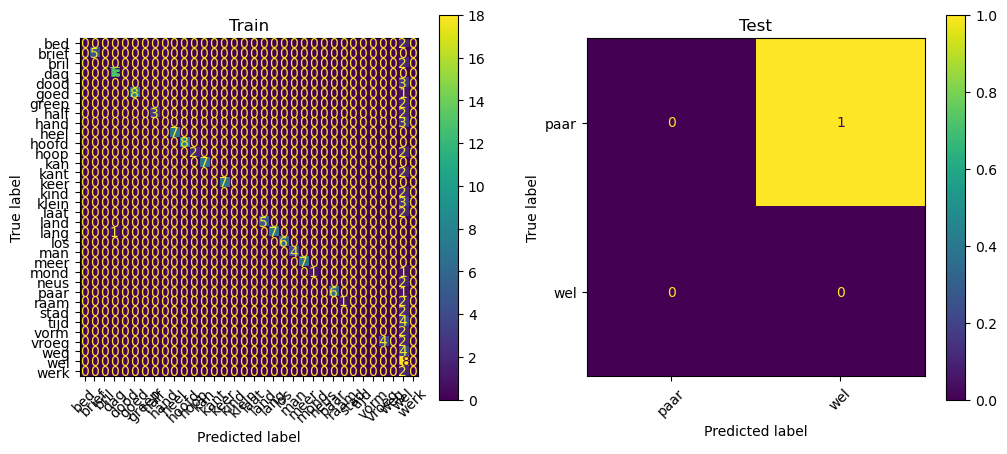

In [906]:
plt.figure(figsize=(12,5))
ax1 = plt.subplot(121)
ax1.set_title('Train')
ConfusionMatrixDisplay.from_estimator(clf, X_train, y_train, ax=ax1, xticks_rotation=45)
ax2 = plt.subplot(122)
ax2.set_title('Test')
ConfusionMatrixDisplay.from_estimator(clf, X_test, y_test, ax=ax2, xticks_rotation=45)
plt.show()

Some additional exploration: reducing dimensionality with TSNE to check along what features the data may cluster. We can see in the plots below that there is no visible correspondence for labels (left plot), while the original length (i.e. number of added zeros) gets picked up on (right plot).

In [563]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random').fit_transform(np.array(data))

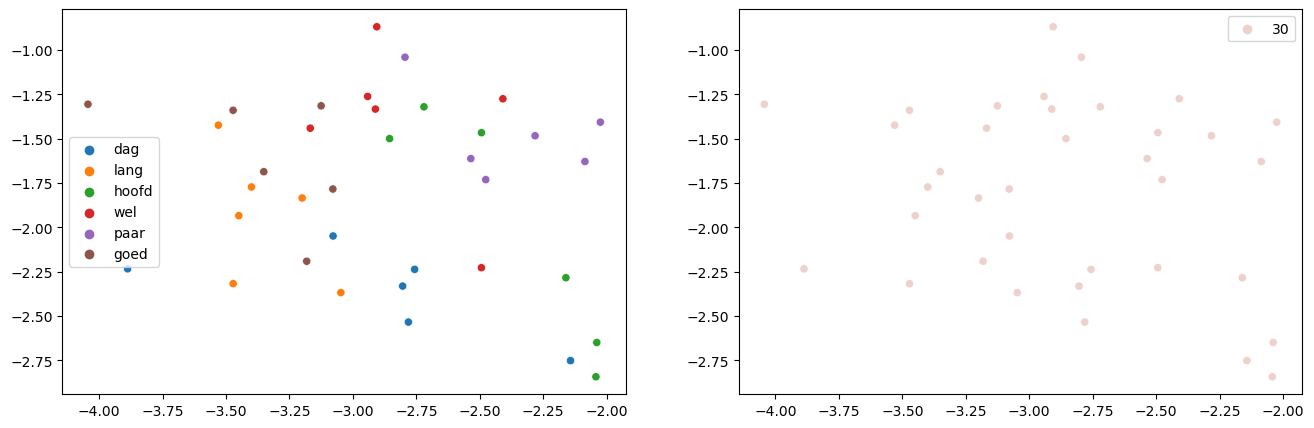

In [564]:
plt.figure(figsize=(16,5))
plt.subplot(121)
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=labels)
plt.subplot(122)
sns.scatterplot(x=X_embedded[:,0], y=X_embedded[:,1], hue=lengths)
plt.show()

## Some additional plots

This plots the distribution of lengths of the different ECoG samples. Useful for determining which `SEGMENT_LENGTH` to use.

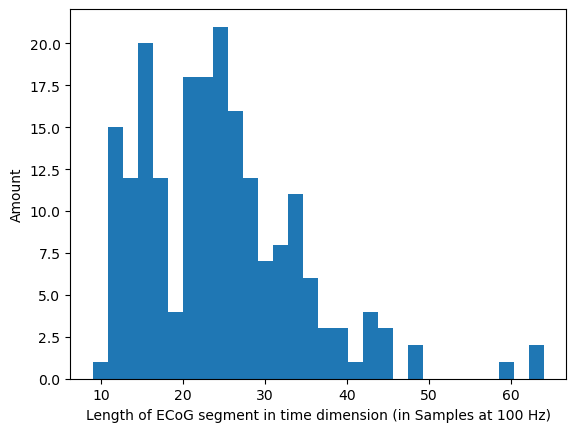

Mean and median lengths: 24.47 23.5


In [11]:
plt.hist(lengths, bins=30)
plt.xlabel('Length of ECoG segment in time dimension (in Samples at 100 Hz)')
plt.ylabel('Amount')
plt.show()
print('Mean and median lengths:', np.mean(lengths), np.median(lengths))

Here we can plot a random ECoG file. We can see the difference between high and low frequency bands.

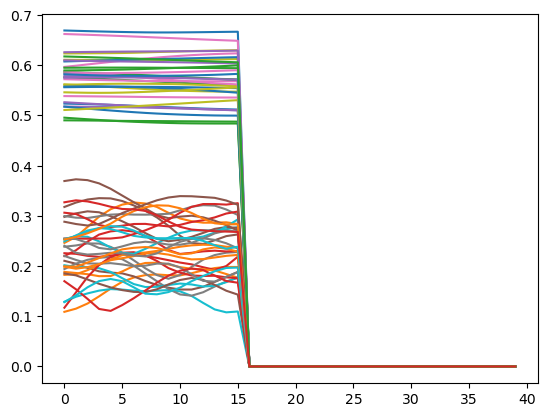

In [12]:
interval =  variaNTS_intervals[np.random.choice(len(variaNTS_intervals))]

ecog_lfb = ecog_df_lfb.iloc[
    math.floor(interval.xmin * ECOG_SAMPLERATE) :
    math.ceil(interval.xmax * ECOG_SAMPLERATE) + 1
    # math.floor(interval.xmin * ECOG_SAMPLERATE) + 20
]
ecog_hfb = ecog_df_hfb.iloc[
    math.floor(interval.xmin * ECOG_SAMPLERATE) :
    math.ceil(interval.xmax * ECOG_SAMPLERATE) + 1
    # math.floor(interval.xmin * ECOG_SAMPLERATE) + 20
]

ecog = np.stack([ecog_lfb.T, ecog_hfb.T], axis=1) # Gives shape (ELECTRODES, FREQ BANDS, TIMESTEPS)
ecog = normalize(ecog, 5, 11)
ecog = fix_length(ecog, SEGMENT_LENGTH)

for i in range(len(ecog)):
    plt.plot(ecog[i, 0, :])
    plt.plot(ecog[i, 1, :])